In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display
import seaborn as sns
import IPython.display

In [2]:
eq_df = pd.read_csv('./large_data/eq_harmony_combined.csv')
display(eq_df)

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
0,children_playing,5.929216,5.157348,5.165380,5.563031,5.046141,5.564920,5.776320,6.222735,5.007891,...,0.808725,0.608560,0.552146,9.255638,1,0.000011,8.845374e-05,150.472464,4,5
1,children_playing,0.393928,0.369925,0.286040,0.234562,0.166241,0.137337,0.112779,0.137284,0.256864,...,5.756093,4.326530,3.608999,10.187929,1,0.002384,7.574148e-06,52.204787,2,10
2,street_music,3.980402,5.639204,8.452841,13.437525,19.415338,35.319351,61.852247,62.117064,69.794119,...,4.442734,3.375018,3.069331,7.897027,1,0.000030,6.712090e-05,332.313043,4,7
3,engine_idling,49.217855,118.563553,413.636333,356.165592,298.137279,250.708116,187.251374,154.515099,123.041750,...,7.791927,5.879618,5.338780,2.837097,1,0.013045,2.409356e-07,132.342029,16,10
4,jackhammer,32.283071,64.291137,87.047839,95.002994,83.547205,78.752242,62.357059,56.717538,47.499636,...,6.121235,4.655034,3.885653,7.351516,1,0.000003,7.250180e-07,77.518617,64,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,drilling,226.917157,131.379454,94.685060,74.815301,52.637036,41.411663,29.911901,26.653218,25.754017,...,22.676630,17.008773,15.437346,13.399563,1,0.000049,1.228996e-05,0.084806,3,8
8728,street_music,1.150492,1.121215,1.201931,1.686691,3.390091,4.478639,7.423455,8.174720,13.878955,...,3.904974,2.969251,2.703057,7.174449,1,0.000084,1.561267e-06,57.223188,5,9
8729,jackhammer,8.035297,7.375843,10.444401,14.958574,30.222577,33.422335,57.759712,66.668939,61.394004,...,20.074697,15.299449,13.888320,7.165302,1,0.000058,8.202671e-07,176.976608,15,1
8730,street_music,6.834364,5.770494,6.197091,6.069610,6.333885,6.242182,5.731609,5.280899,4.798209,...,3.483784,2.613115,2.370264,14.280547,2,0.000007,9.653588e-07,211.814493,3,3


After initial attempts performed relatively poorly, I decided to try to add another classifier object. Crest factor is the ratio of the maximum amplitude of a signal to its root mean square. As such, I expect short, loud sounds like gunshots to exhibit large crest factors.

After initial attempts with the crest factor I noticed that a number of the audio samples have significant "room noise" present. In an attempt to clean this up I'm taking the hilbert transform (extracts the instantaneous amplitude of a signal). Smoothing this transform and dividing by the root mean square power should then amplify the parts of the signal that are large in amplitude, while minimizing the areas that are simply a constant amplitude "hum". Low crest factor systems will be largely unaffected as the root mean square will be similar to the root mean square of the signal for such signals. Finally we ensure that the maximum amplitude of the signal is scaled to be equal to the input signal.

In [3]:
nansvec = np.isnan(eq_df['crestfactor'])
nansvec[nansvec==True]

Series([], Name: crestfactor, dtype: bool)

In [4]:
eq_df['power_ratio'] = np.log10(eq_df['percussive_power'].values / (eq_df['harmonic_power'].values))

In [5]:
eq_df['hits_ratio'] = np.log10(eq_df['percussive_hits'].values / (eq_df['harmonic_hits'].values + 1e-1) + 5e-4)

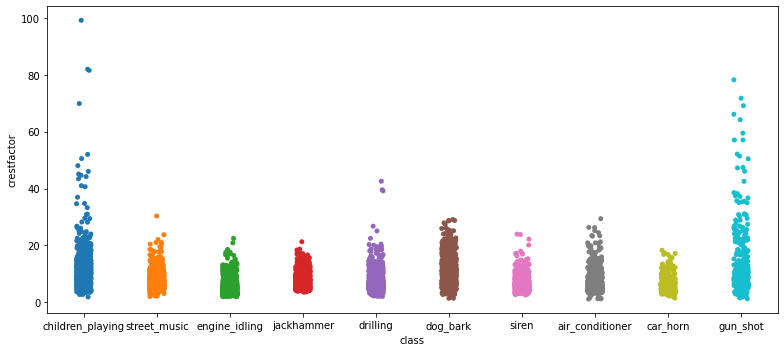

In [6]:
plt.figure(figsize=(11,5))
sns.stripplot(data = eq_df,
             x = 'class',
             y = 'crestfactor')
plt.tight_layout()
plt.show()

In [7]:
display(eq_df)

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold,power_ratio,hits_ratio
0,children_playing,5.929216,5.157348,5.165380,5.563031,5.046141,5.564920,5.776320,6.222735,5.007891,...,0.552146,9.255638,1,0.000011,8.845374e-05,150.472464,4,5,0.889862,-1.567587
1,children_playing,0.393928,0.369925,0.286040,0.234562,0.166241,0.137337,0.112779,0.137284,0.256864,...,3.608999,10.187929,1,0.002384,7.574148e-06,52.204787,2,10,-2.498050,-1.411869
2,street_music,3.980402,5.639204,8.452841,13.437525,19.415338,35.319351,61.852247,62.117064,69.794119,...,3.069331,7.897027,1,0.000030,6.712090e-05,332.313043,4,7,0.354830,-1.901937
3,engine_idling,49.217855,118.563553,413.636333,356.165592,298.137279,250.708116,187.251374,154.515099,123.041750,...,5.338780,2.837097,1,0.013045,2.409356e-07,132.342029,16,10,-4.733537,-0.916112
4,jackhammer,32.283071,64.291137,87.047839,95.002994,83.547205,78.752242,62.357059,56.717538,47.499636,...,3.885653,7.351516,1,0.000003,7.250180e-07,77.518617,64,1,-0.669574,-0.083523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,drilling,226.917157,131.379454,94.685060,74.815301,52.637036,41.411663,29.911901,26.653218,25.754017,...,15.437346,13.399563,1,0.000049,1.228996e-05,0.084806,3,8,-0.600461,1.210419
8728,street_music,1.150492,1.121215,1.201931,1.686691,3.390091,4.478639,7.423455,8.174720,13.878955,...,2.703057,7.174449,1,0.000084,1.561267e-06,57.223188,5,9,-1.732981,-1.056878
8729,jackhammer,8.035297,7.375843,10.444401,14.958574,30.222577,33.422335,57.759712,66.668939,61.394004,...,13.888320,7.165302,1,0.000058,8.202671e-07,176.976608,15,1,-1.845987,-1.069514
8730,street_music,6.834364,5.770494,6.197091,6.069610,6.333885,6.242182,5.731609,5.280899,4.798209,...,2.370264,14.280547,2,0.000007,9.653588e-07,211.814493,3,3,-0.853331,-1.833965


In [8]:
eq_df = eq_df.dropna()

In [9]:
nansvec = np.isnan(eq_df['crestfactor'])
nansvec[nansvec==True]

Series([], Name: crestfactor, dtype: bool)

In [10]:
# try classifying with the log instead?
for i in range(0,len(eq_df)):
    eq_df.iloc[i,1:-9] = np.log10(eq_df.iloc[i,1:-9].values.astype(float))

In [11]:
def TPR(prediction, data, numclasses):
    """
    Returns True Positive Ratio given a prediction and data
    """
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    TP = np.zeros(numclasses)
    FN = np.zeros(numclasses)
    R = np.zeros(numclasses)
    for i in range(numclasses):
        TP[i] = confmat[i,i]
        FN[i] = confmat[i,:].sum() - confmat[i,i]
    
    R = TP/(TP + FN)
    
    
    return R
    

In [12]:
def recall(prediction, data, numclasses):
    """
    Calculates recall of a prediction
    """
    
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
#     TP = confmat[6,6]
#     FN = confmat[6,:] - confmat[6,6]
    TP = np.zeros(numclasses)
    R = np.zeros(numclasses)
    FN = np.zeros(numclasses)
    for i in range(numclasses):
        TP[i] = confmat[i,i]
        FN[i] = confmat[i,:].sum() - confmat[i,i]
    
    R = TP/(TP + FN)
    
    return R

def precision(prediction, data,numclasses):
    """
    Calculates precision of a prediction
    """
    
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
#     TP = confmat[6,6]
#     FP = confmat[:,6].sum() - confmat[6,6]
    TP = np.zeros(numclasses)
    FN = np.zeros(numclasses)
    P = np.zeros(numclasses)
    for i in range(numclasses):
        TP[i] = confmat[i,i]
        FP[i] = confmat[:,i].sum() - confmat[i,i]
    
    P = TP/(TP + FP)
    
    return P

In [13]:
def Fmeasure(prediction, data, numclasses):
    """
    Returns Fmeasure. 
    
    This is considered a balance of the precision and the recall.
    
    F = (2*P*R)/(P+R)
    
    where
    
    P = TP/(TP + FP) is the precision and
    R = TP/(TP + FN) is the recall.
    
    Reference: 
    Müller, Meinard. Fundamentals of music processing: Audio, analysis, algorithms, applications. 
    Vol. 5. Cham: Springer, 2015.
    Sec. 4.5 pp. 217
    """
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
#     TP = confmat[6,6]
#     FN = confmat[6,:].sum() - confmat[6,6]
#     FP = confmat[:,6].sum() - confmat[6,6]
    TP = np.zeros(numclasses)
    FN = np.zeros(numclasses)
    FP = np.zeros(numclasses)
    P = np.zeros(numclasses)
    R = np.zeros(numclasses)
    for i in range(numclasses):
        TP[i] = confmat[i,i]
        FN[i] = confmat[i,:].sum() - confmat[i,i]
        FP[i] = confmat[:,i].sum() - confmat[i,i]
    
    P = TP/(TP + FP)
    R = TP/(TP + FN)
    
    F = (2*P*R)/(P + R)

    return F
    

In [14]:
eq_df2 = eq_df.copy()
eq_df2.replace({'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4,
                'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9},inplace=True)
# eq_df2.replace({'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4,
#                 'engine_idling':0, 'gun_shot':5, 'jackhammer':4, 'siren':6, 'street_music':2},inplace=True)
# eq_df2.replace({'air_conditioner':0, 'car_horn':0, 'children_playing':0, 'dog_bark':0, 'drilling':0,
#                 'engine_idling':0, 'gun_shot':1, 'jackhammer':0, 'siren':0, 'street_music':0},inplace=True)

Documentation of the dataset suggests not shuffling the dataset. This is because there are a number of audio files that are taken as sections from longer audio files and will result in anomalous results if these are shuffled together. Instead the dataset has included a psuedorandom "fold" category to serve as splits for cross validation. 

In [15]:
dropfold = 1

In [16]:
eq_df3 = eq_df2.drop(eq_df2[eq_df2['fold']==dropfold].index)

In [17]:
eq_df3[eq_df3['fold']==dropfold].values

array([], shape=(0, 33), dtype=float64)

In [18]:
eq_df3.drop(columns='fold',inplace=True)

In [19]:
eq_df3.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,power_ratio,hits_ratio
0,2,0.772997,0.712426,0.713102,0.745311,0.702959,0.745459,0.761651,0.793981,0.699655,...,-0.215696,-0.257946,9.255638,1,0.000011,8.845374e-05,150.472464,4,0.889862,-1.567587
1,2,-0.404583,-0.431886,-0.543574,-0.629743,-0.779261,-0.862212,-0.947772,-0.862379,-0.590296,...,0.636140,0.557387,10.187929,1,0.002384,7.574148e-06,52.204787,2,-2.498050,-1.411869
2,9,0.599927,0.751218,0.927003,1.128319,1.288145,1.548013,1.791355,1.793211,1.843819,...,0.528276,0.487044,7.897027,1,0.000030,6.712090e-05,332.313043,4,0.354830,-1.901937
3,5,1.692123,2.073951,2.616619,2.551652,2.474416,2.399168,2.272425,2.188971,2.090052,...,0.769349,0.727442,2.837097,1,0.013045,2.409356e-07,132.342029,16,-4.733537,-0.916112
5,5,0.946868,1.046500,1.016238,0.981577,1.004380,1.108758,1.334478,1.561918,1.548040,...,0.072507,-0.005021,3.722183,1,0.001770,3.998450e-07,1067.550532,0,-3.646108,-3.301030


In [20]:
eq_df3.iloc[1,1:].values

array([-4.04582691e-01, -4.31886134e-01, -5.43573620e-01, -6.29742627e-01,
       -7.79261405e-01, -8.62212262e-01, -9.47772406e-01, -8.62378959e-01,
       -5.90296226e-01, -3.96394678e-01, -6.63414195e-02,  2.18695427e-01,
        4.26148422e-01,  1.30008700e+00,  1.39173557e+00,  1.36937873e+00,
        1.26498401e+00,  1.20158442e+00,  1.04997989e+00,  9.29720030e-01,
        7.60127767e-01,  6.36139671e-01,  5.57386808e-01,  1.01879292e+01,
        1.00000000e+00,  2.38442620e-03,  7.57414798e-06,  5.22047872e+01,
        2.00000000e+00, -2.49805010e+00, -1.41186933e+00])

In [21]:
X_train = eq_df3.iloc[:,1:].values
# X_train = [eq_df3.iloc[:,1:-2].values, eq_df3.iloc[:,-1]]
X_train

array([[ 0.7729973 ,  0.71242643,  0.71310227, ...,  4.        ,
         0.88986188, -1.56758744],
       [-0.40458269, -0.43188613, -0.54357362, ...,  2.        ,
        -2.4980501 , -1.41186933],
       [ 0.59992689,  0.75121781,  0.92700271, ...,  4.        ,
         0.35482961, -1.90193726],
       ...,
       [ 0.06088342,  0.04968881,  0.07987968, ...,  5.        ,
        -1.73298128, -1.05687793],
       [ 0.83469809,  0.76121296,  0.79218785, ...,  3.        ,
        -0.85333115, -1.83396519],
       [-1.03094911, -1.03258675, -1.02254984, ...,  8.        ,
        -1.95872738, -0.94843748]])

In [22]:
y_train = eq_df3.iloc[:,0].values
y_train

array([2, 2, 9, ..., 9, 9, 4])

In [23]:
X_val = eq_df2[eq_df2['fold'] == dropfold].copy()
X_val.drop(columns='fold',inplace=True)
X_val = X_val.iloc[:,1:].values
y_val = eq_df2[eq_df2['fold'] == dropfold]
y_val = y_val.iloc[:,0].values

In [24]:
np.any(np.isinf(X_val))

False

In [25]:
y_val

array([7, 8, 9, 2, 8, 3, 2, 5, 0, 4, 7, 7, 9, 4, 4, 0, 3, 9, 3, 6, 4, 7,
       7, 4, 5, 8, 4, 5, 7, 2, 2, 9, 6, 9, 9, 4, 0, 9, 3, 7, 3, 9, 3, 9,
       2, 5, 0, 8, 7, 6, 5, 7, 7, 6, 8, 6, 4, 3, 7, 5, 2, 5, 5, 9, 0, 2,
       5, 4, 0, 8, 8, 7, 2, 0, 7, 7, 2, 2, 9, 3, 1, 6, 4, 3, 4, 0, 9, 9,
       7, 9, 0, 2, 5, 2, 4, 5, 0, 7, 7, 2, 2, 4, 0, 9, 4, 7, 7, 9, 8, 9,
       0, 2, 9, 2, 8, 1, 2, 6, 0, 7, 7, 2, 2, 2, 9, 3, 9, 6, 4, 3, 3, 4,
       9, 7, 9, 9, 9, 5, 9, 5, 8, 0, 9, 8, 8, 3, 7, 7, 9, 2, 9, 4, 3, 6,
       4, 7, 8, 0, 4, 4, 0, 8, 1, 8, 5, 0, 4, 7, 7, 1, 3, 3, 1, 6, 4, 0,
       3, 4, 9, 7, 3, 3, 5, 8, 5, 3, 9, 2, 5, 0, 3, 7, 7, 2, 3, 9, 0, 4,
       7, 7, 2, 0, 8, 2, 3, 2, 5, 0, 7, 7, 9, 8, 0, 4, 2, 7, 5, 5, 0, 2,
       2, 2, 9, 6, 5, 7, 7, 7, 6, 4, 1, 5, 4, 0, 9, 3, 4, 7, 7, 5, 5, 5,
       8, 8, 2, 2, 5, 5, 0, 7, 2, 6, 4, 8, 4, 0, 0, 4, 2, 5, 9, 3, 8, 5,
       0, 2, 2, 5, 9, 2, 8, 8, 8, 2, 5, 0, 7, 7, 9, 3, 9, 0, 3, 6, 2, 9,
       8, 5, 0, 5, 4, 0, 8, 1, 5, 0, 1, 7, 7, 7, 9,

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
mlp = MLPClassifier(hidden_layer_sizes=(150,150,150,150,150,), max_iter=100000,early_stopping=True)

In [28]:
mlp.fit(X_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(150, 150, 150, 150, 150),
              max_iter=100000)

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Here we consider the True Positive Rate for the gunshot data as an indicator of the goodness of fit. Interestingly this is often higher when the classifier can classify into multiple categories than simply gunshot/not gunshot.

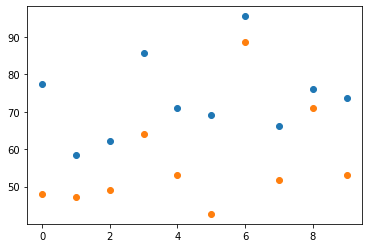

In [30]:
# confmat = confusion_matrix(y_train, mlp.predict(X_train))
# acc = 100*confmat[1,1] / (np.sum(np.sum(confmat[1,:])))
# print("Training accuracy of", acc)
# confmat = confusion_matrix(y_val, mlp.predict(X_val))
# acc = 100*confmat[1,1] / (np.sum(confmat[1,:]))
# print("Validation accuracy of", acc)

# confmat = confusion_matrix(y_train, mlp.predict(X_train))
# acc = 100*confmat[6,6] / (np.sum(np.sum(confmat[6,:])))
acc =100*TPR(y_train, mlp.predict(X_train),10)
acc2 =100*Fmeasure(y_train, mlp.predict(X_train),10)
plt.scatter(range(10),acc)
# print("Training TPR of", acc, "Fmeasure of", acc2)
# confmat = confusion_matrix(y_val, mlp.predict(X_val))
# acc = 100*confmat[6,6] / (np.sum(confmat[6,:]))
acc = 100*TPR(y_val, mlp.predict(X_val),10)
acc2 = 100*Fmeasure(y_val, mlp.predict(X_val),10)
plt.scatter(range(10),acc)
# print("Validation TPR of", acc, "Fmeasure of", acc2)

In [31]:
pd.DataFrame(confusion_matrix(y_val, mlp.predict(X_val)),
            columns=["predicted "+str(i) for i in range(10)],
            index=["actual "+str(i) for i in range(10)])

# pd.DataFrame(confusion_matrix(y_val, mlp.predict(X_val)),
#             columns=["predicted "+str(i) for i in range(2)],
#             index=["actual "+str(i) for i in range(2)])

,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4,predicted 5,predicted 6,predicted 7,predicted 8,predicted 9
actual 0,48,3,6,7,1,5,0,15,1,14
actual 1,2,17,0,1,6,2,0,0,6,2
actual 2,2,2,49,15,5,8,2,0,6,11
actual 3,2,2,14,64,5,2,2,0,5,4
actual 4,1,7,8,10,53,8,1,1,2,9
actual 5,27,0,3,6,15,41,0,0,0,4
actual 6,0,0,1,0,2,0,31,0,0,1
actual 7,0,0,0,0,34,9,0,62,0,15
actual 8,4,7,7,1,0,2,2,0,61,2
actual 9,9,3,13,1,11,5,0,3,2,53


As suggested by the dataset the most accurate results for a classifier are acheived when averaged over the different possible test/validation splits.

In [34]:
accuracy_vec = np.zeros(10)
for dropfold in range(1,11):
    eq_df2 = eq_df.copy()
    eq_df2.replace({'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4,
                'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9},inplace=True)
#     eq_df2.replace({'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4,
#                 'engine_idling':0, 'gun_shot':6, 'jackhammer':4, 'siren':8, 'street_music':2},inplace=True)
#     eq_df2.replace({'air_conditioner':0, 'car_horn':0, 'children_playing':0, 'dog_bark':0, 'drilling':0,
#                     'engine_idling':0, 'gun_shot':1, 'jackhammer':0, 'siren':0, 'street_music':0},inplace=True)

    eq_df3 = eq_df2.drop(eq_df2[eq_df2['fold']==dropfold].index)
    eq_df3.drop(columns='fold',inplace=True)
    X_train = eq_df3.iloc[:,1:].values
    y_train = eq_df3.iloc[:,0].values
    
#     X_val = eq_df2[eq_df2['fold'] == dropfold]
#     X_val = X_val.iloc[:,1:].values
#     y_val = eq_df2[eq_df2['fold'] == dropfold]
#     y_val = y_val.iloc[:,0].values
    
    X_val = eq_df2[eq_df2['fold'] == dropfold].copy()
    X_val.drop(columns='fold',inplace=True)
    X_val = X_val.iloc[:,1:].values
    y_val = eq_df2[eq_df2['fold'] == dropfold]
    y_val = y_val.iloc[:,0].values
    
    mlp = MLPClassifier(hidden_layer_sizes=(150,150,150,150,150,), max_iter=100000, early_stopping=True)
    mlp.fit(X_train, y_train)
#     acc = 100*Fmeasure(y_val, mlp.predict(X_val),7)
    acc = 100*TPR(y_val, mlp.predict(X_val),10)[6]
#     acc = 100*TPR(y_val, mlp.predict(X_val),7)[5]
    print("Validation TPR of", acc, "on fold", str(dropfold))
    accuracy_vec[dropfold-1] = acc
    
print(accuracy_vec)
accuracy_vec.mean()

Validation TPR of 71.42857142857143 on fold 1
Validation TPR of 94.28571428571428 on fold 2
Validation TPR of 94.44444444444444 on fold 3
Validation TPR of 71.05263157894737 on fold 4
Validation TPR of 100.0 on fold 5
Validation TPR of 100.0 on fold 6
Validation TPR of 84.31372549019608 on fold 7
Validation TPR of 90.0 on fold 8
Validation TPR of 90.32258064516128 on fold 9
Validation TPR of 62.5 on fold 10
[ 71.42857143  94.28571429  94.44444444  71.05263158 100.
 100.          84.31372549  90.          90.32258065  62.5       ]


85.8347667873035